In [1]:
import tqdm
import pickle
import warnings
import datetime

import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

from meteostat import Point, Daily

from statsmodels.tsa.seasonal import STL

from sklearn.metrics import mean_squared_error
from sklearn.multioutput import MultiOutputRegressor
from sklearn.ensemble import GradientBoostingRegressor

In [2]:
sns.set()
pd.options.display.float_format = '{:,.2f}'.format

warnings.simplefilter("ignore")

### Загрузка и обработка данных

Устанавливаем 5-летний период времени для предсказания погоды. И устанавливаем локацию - координаты Санкт-Петербурга.

In [3]:
start = datetime.datetime(2019, 1, 1)
end = datetime.datetime(2023, 12, 31)

location = Point(59.938678, 30.314474)

In [4]:
data = Daily(location, start, end)
data = data.fetch()

In [5]:
data

,tavg,tmin,tmax,prcp,snow,wdir,wspd,wpgt,pres,tsun
time,,,,,,,,,,
2019-01-01,-0.80,-2.50,1.10,3.50,170.00,179.00,18.60,44.50,996.20,NaN
2019-01-02,0.20,-1.80,1.60,3.50,140.00,160.00,10.50,25.90,994.60,NaN
2019-01-03,-3.10,-3.50,-1.80,1.30,150.00,12.00,17.40,29.60,"1,015.40",NaN
2019-01-04,-6.70,-6.90,-3.20,2.40,150.00,202.00,9.60,18.50,"1,014.40",NaN
2019-01-05,-5.10,-7.10,-3.60,0.70,170.00,56.00,8.10,18.50,"1,014.10",NaN
...,...,...,...,...,...,...,...,...,...,...
2023-12-27,-4.50,-9.00,-2.00,1.00,221.00,238.00,6.00,11.10,997.80,NaN
2023-12-28,-3.30,-8.80,-1.00,0.00,221.00,227.00,9.30,14.80,"1,008.20",NaN
2023-12-29,-2.80,-3.00,-2.20,4.00,NaN,105.00,13.20,24.10,998.20,NaN


In [6]:
data.isna().sum()

tavg       0
tmin       0
tmax       0
prcp       5
snow    1452
wdir       5
wspd       0
wpgt       0
pres       0
tsun    1826
dtype: int64

Уберем всегда пустую колонку. Также уберем `tmin` и `tmax`, т.к. они сильно коррелируют с `tavg`.

In [7]:
data = data.drop(["tsun", "tmin", "tmax"], axis=1)

Заметим, что `NaN` в колонках `snow` и `prcp` соответствуют отсутствию осадков.

In [8]:
data["snow"] = data["snow"].fillna(0)
data["prcp"] = data["prcp"].fillna(0)

Учитывая небольшое количество пропусков для направления ветра `wdir` заполним значения предыдущим днем.

In [9]:
data["wdir"] = data["wdir"].bfill()

In [10]:
data.mean()

tavg       6.78
prcp       1.78
snow      30.99
wdir     199.11
wspd      12.02
wpgt      26.56
pres   1,012.01
dtype: float64

Общая функция для препроцессинга:

In [11]:
def preprocess_data(data):
    data = data.drop(["tsun", "tmin", "tmax"], axis=1)
    data["snow"] = data["snow"].fillna(0)
    data["prcp"] = data["prcp"].fillna(0)
    # пытаемся заполнить данными, которые есть, иначе берем среднее по датасету
    data["wdir"] = data["wdir"].bfill().ffill().fillna(200)
    return data

### Анализ данных

Теперь визуализируем данные.

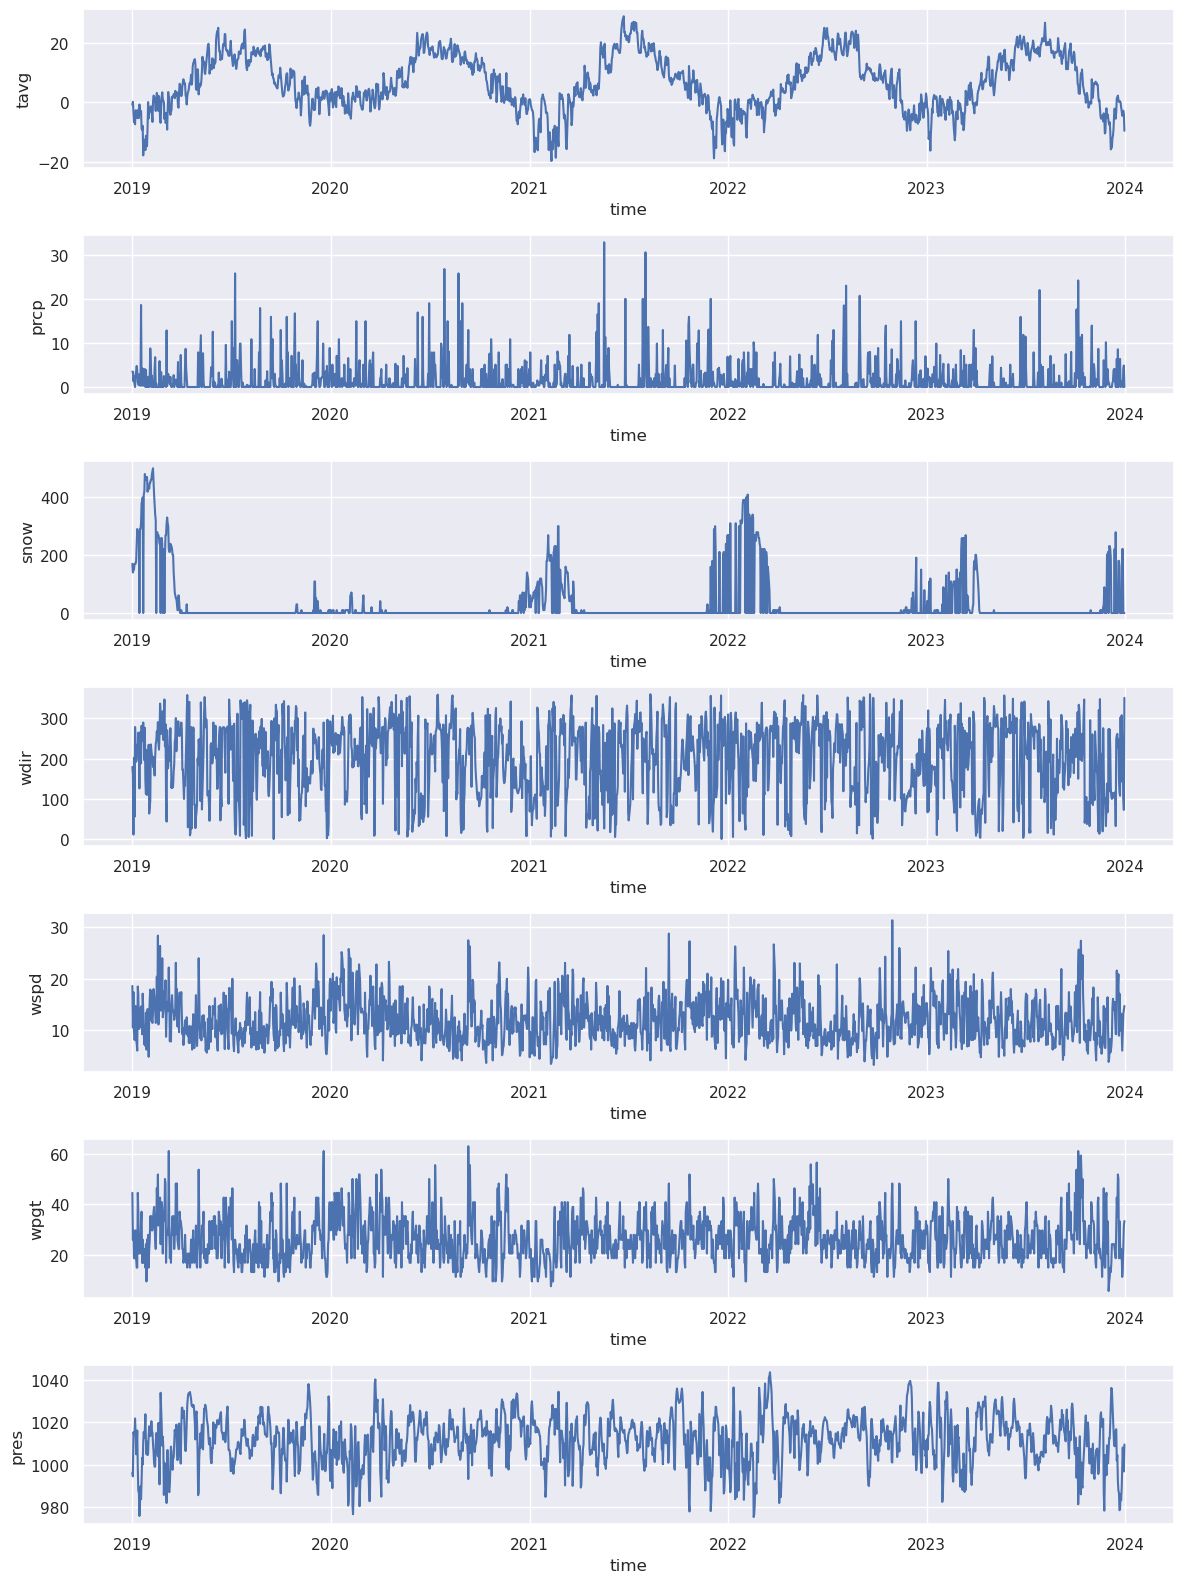

In [12]:
fig, axes = plt.subplots(nrows=7, ncols=1, figsize=(12, 16))

for i, column in enumerate(data.columns):
    sns.lineplot(ax=axes[i], data=data[column])

plt.tight_layout()
plt.show()

Теперь посмотрим на корреляции между данными.

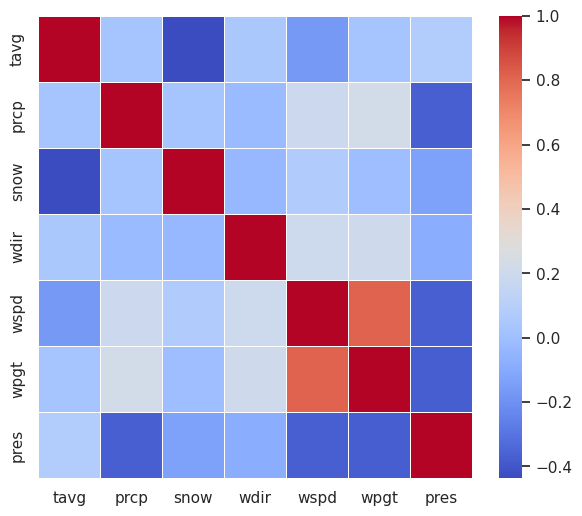

In [13]:
plt.figure(figsize=(7, 6))
sns.heatmap(data.corr(), cmap='coolwarm', linewidths=.5)
plt.show()

Посмотрим, как температура разбивается на компоненты, как временной ряд:

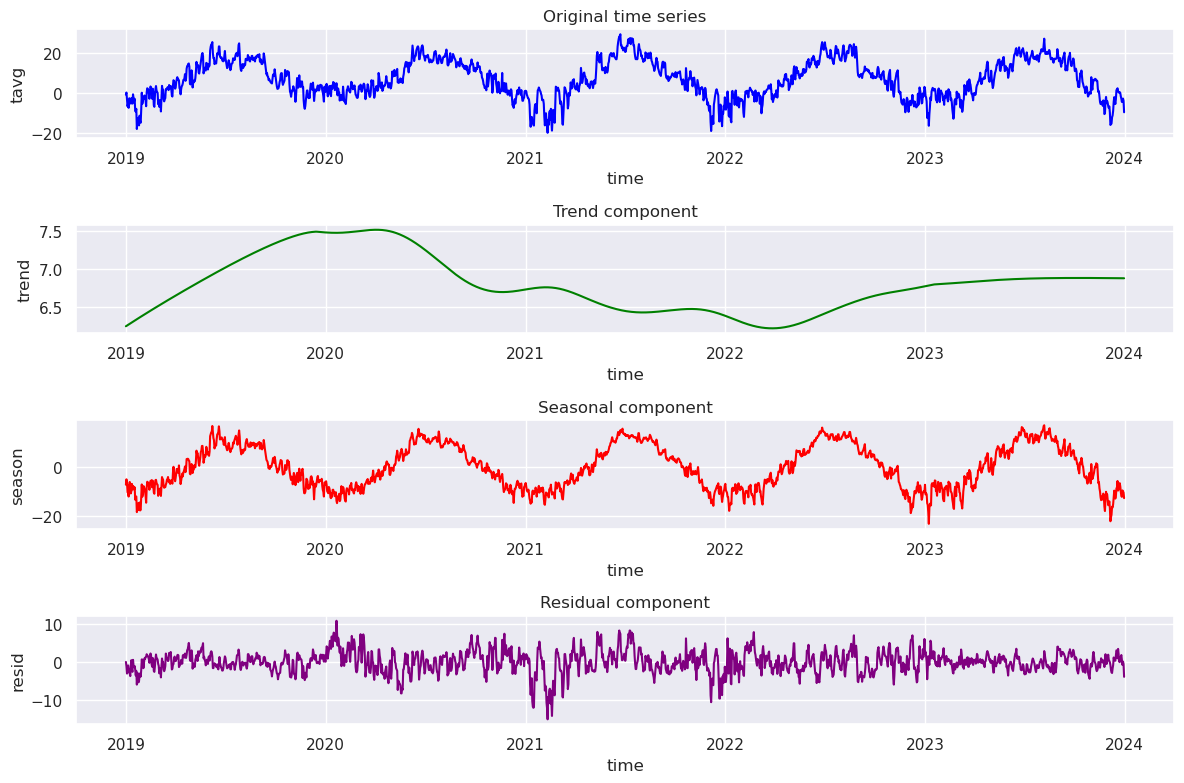

In [14]:
stl = STL(data["tavg"], period=365)
result = stl.fit()

plt.figure(figsize=(12, 8))

plt.subplot(4, 1, 1)
sns.lineplot(data["tavg"], color='blue')
plt.title('Original time series')

plt.subplot(4, 1, 2)
sns.lineplot(result.trend, color='green')
plt.title('Trend component')

plt.subplot(4, 1, 3)
sns.lineplot(result.seasonal, color='red')
plt.title('Seasonal component')

plt.subplot(4, 1, 4)
sns.lineplot(result.resid, color='purple')
plt.title('Residual component')

plt.tight_layout()
plt.show()

### Обучение модели

В качестве тестового датасета будем использовать данные за последний год.

In [15]:
data_train = data[:-365]
data_test = data[-365:]

Для предсказаний будем использовать гибридную стратегию.

In [16]:
def extract_features(data: pd.DataFrame, model_idx: int, window_size: int = 3):
    feature_window = window_size + model_idx
    data = data[-feature_window:]
    values = data.values.reshape(-1)
    date = data.index[-1] + datetime.timedelta(days=1 + model_idx)
    day = (date - start).days
    month = date.month
    return np.concatenate([values, [day, month]])

In [17]:
def build_datasets(data: pd.DataFrame, window_size: int = 3, model_count: int = 3):
    datasets = []
    n = len(data)

    for i in range(model_count):
        features = np.array([extract_features(data[:j], i, window_size) for j in range(window_size + i, n)])
        targets = data[window_size + i:].values
        datasets.append((features, targets))

    return datasets

In [18]:
def train_models(data: pd.DataFrame, model_type, model_kwargs, model_count: int = 3, window_size: int = 3):
    models = []
    datasets = build_datasets(data, window_size, model_count)

    for i in tqdm.trange(model_count):
        model = MultiOutputRegressor(model_type(**model_kwargs))
        model.fit(*datasets[i])
        models.append(model)

    return models

In [19]:
def predict(data: pd.DataFrame, models, window_size: int = 3):
    last_date = data.index[-1]
    for i, model in enumerate(models):
        features = extract_features(data, i, window_size).reshape(1, -1)
        last_date += datetime.timedelta(days=1)
        prediction = pd.DataFrame(model.predict(features), index=[last_date], columns=data.columns)
        data = pd.concat([data, prediction], axis=0)
    return data[-len(models):]

In [20]:
def score_models(data_test, models, window_size: int = 3):
    input_size = len(data_test)
    predict_size = len(models)

    n_predictions = input_size - window_size - predict_size + 1
    predictions = np.zeros((n_predictions, predict_size))
    targets = np.zeros((n_predictions, predict_size))

    for i in tqdm.trange(n_predictions):
        predictions[i] = predict(data_test[:window_size + i], models, window_size)["tavg"].values
        targets[i] = data_test[window_size + i:window_size + predict_size + i]["tavg"].values

    return np.mean(np.abs(targets - predictions), axis=0)

In [21]:
window_size = 7
predict_size = 7

In [22]:
models = train_models(data_train, GradientBoostingRegressor, {"n_estimators": 200}, predict_size, window_size)

100%|█████████████████████████████████████████████| 7/7 [02:42<00:00, 23.28s/it]


In [23]:
score_models(data_test, models, window_size)

100%|█████████████████████████████████████████| 352/352 [00:09<00:00, 36.17it/s]


array([2.18952808, 2.94609747, 3.03825659, 3.28511796, 3.49847958,
       3.68767997, 3.75492725])

### Сохранение модели

In [24]:
with open("model.pkl", "wb") as file:
    pickle.dump(models, file)

In [25]:
with open("model.pkl", "rb") as file:
    models = pickle.load(file)

In [26]:
predict(data_test, models, window_size)

,tavg,prcp,snow,wdir,wspd,wpgt,pres
2024-01-01,-8.84,0.74,107.02,263.68,13.32,28.45,"1,015.82"
2024-01-02,-4.92,1.72,132.80,204.73,11.91,28.50,"1,012.75"
2024-01-03,-4.03,0.89,94.60,189.61,11.44,30.00,"1,011.51"
2024-01-04,-4.28,2.03,86.61,210.75,13.74,28.49,"1,010.54"
2024-01-05,-2.96,2.32,83.32,213.15,13.55,27.81,"1,010.55"
2024-01-06,-1.67,3.01,53.46,237.02,12.35,27.62,"1,011.23"
2024-01-07,-0.83,1.27,17.23,227.24,13.05,27.74,"1,008.50"
